In [ ]:
!pip install -U transformers datasets accelerate scikit-learn matplotlib seaborn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 133.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 157.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import transformers

print("✅ Transformers version:", transformers.__version__)
print("✅ PyTorch version:", torch.__version__)


✅ Transformers version: 4.57.1
✅ PyTorch version: 2.8.0+cu126


#Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving eng_clean.csv to eng_clean.csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving spa_clean.csv to spa_clean.csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving deu_clean.csv to deu_clean.csv


In [ ]:
df_eng = pd.read_csv("eng_clean.csv", encoding="utf-8")
print(df_eng.shape)
print(df_eng.columns)
df_eng.head()


(2671, 3)
Index(['id', 'text', 'polarization'], dtype='object')


,id,text,polarization
0,en_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,en_07dfd4600426caca6e2c5883fcbea9ea,still playing with this i am now following rac...,0
2,en_f14519ff2302b6cd47712073f13bc461,senate gov theres groups out there republicans...,0
3,en_e48b7e7542faafa544ac57b64bc80daf,abc md david anderson said the additional fund...,0
4,en_7c581fb77bce8033aeba3d6dbd6273eb,bad people i have some conservative values so ...,0


In [ ]:
df_spa = pd.read_csv("spa_clean.csv", encoding="utf-8")
print(df_spa.shape)
print(df_spa.columns)
df_spa.head()

(3302, 3)
Index(['id', 'text', 'polarization'], dtype='object')


,id,text,polarization
0,spa_bc7bf0a1b710cd724cf96b5eeb020bff,bueno tirando y si hay repregunta entonces pal...,0
1,spa_688aec0f6abf4e0be44ecbfa886251cc,caimos en su retorica de indigena,0
2,spa_47019efabe7295c630bcc04bd0429230,cara de indigena sudaca porque pio asi luego,0
3,spa_8b4b244dbb90e0a813661ed12a1af5af,violar a una nina es menos grave que un aborto...,1
4,spa_e2f37881da08b8d7b6eb07bc37356746,yo decido quien es judio y quien no,1


In [ ]:
df_deu = pd.read_csv("deu_clean.csv", encoding="utf-8")
print(df_deu.shape)
print(df_deu.columns)
df_deu.head()

(3179, 3)
Index(['id', 'text', 'polarization'], dtype='object')


,id,text,polarization
0,deu_fa07b0533db91281c049fb722ca121d7,natürlich bin ich linksgrün ich habe herz u n d,0
1,deu_10e753b5d49374d2de1f68dfc1e2d249,schuld sind habeck die grünen und diese linksg...,1
2,deu_61be00002367a33400dade564edccc59,vielleicht ist da ja tatsächlich was dran höch...,1
3,deu_d28b20af64d590134448fcdbfbb0f7dd,so noch schnell alle linksgrün versifften demo...,1
4,deu_005fc728be211eae1c308a0fc20d73df,ich drücke der störchin die daumen berlin ist ...,1


================================================================================
#English
================================================================================

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_eng["text"].tolist(),
    df_eng["polarization"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_eng["polarization"]
)

print(f"✅ Training samples: {len(train_texts)}")
print(f"✅ Testing samples: {len(test_texts)}")


✅ Training samples: 2136
✅ Testing samples: 535


In [ ]:
from datasets import Dataset
from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Convert to Hugging Face Dataset format
train_df = pd.DataFrame({"text": train_texts, "labels": train_labels})
test_df  = pd.DataFrame({"text": test_texts,  "labels": test_labels})

train_dataset = Dataset.from_pandas(train_df)
test_dataset  = Dataset.from_pandas(test_df)

# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch",  columns=["input_ids", "attention_mask", "labels"])

print("✅ Tokenization complete! Sample columns:", train_dataset.column_names)


Map:   0%|          | 0/2136 [00:00<?, ? examples/s]

Map:   0%|          | 0/535 [00:00<?, ? examples/s]

✅ Tokenization complete! Sample columns: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Load pretrained model (2 labels = polarized / non-polarized)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define metric function for Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision_macro": p, "recall_macro": r, "f1_macro": f1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

# Create Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()


/tmp/ipython-input-3640713003.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.592500
100,0.501700
150,0.440700
200,0.347000
250,0.362500
300,0.274700
350,0.236000
400,0.206000


TrainOutput(global_step=402, training_loss=0.3692882505815421, metrics={'train_runtime': 166.8172, 'train_samples_per_second': 38.413, 'train_steps_per_second': 2.41, 'total_flos': 421503910686720.0, 'train_loss': 0.3692882505815421, 'epoch': 3.0})

In [ ]:
batch_size = 16  # you can try 32 if GPU allows

training_args = TrainingArguments(
    output_dir="bert_eng_runs",
    do_train=True,               # train the model
    do_eval=True,                # evaluate at each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    report_to=[]                 # disables wandb etc.
)

print("✅ Training arguments ready (compatible mode)")



✅ Training arguments ready (compatible mode)


In [ ]:
# make a folder in Drive for your model
save_path = "/content/drive/MyDrive/POLAR_Task_9/models/english_bert_base_uncased"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Model and tokenizer saved to: {save_path}")

NameError: name 'trainer' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/POLAR_Task_9/models/english_bert_base_uncased",
    local_files_only=True
)
tokenizer = BertTokenizer.from_pretrained(
    "/content/drive/MyDrive/POLAR_Task_9/models/english_bert_base_uncased",
    local_files_only=True
)

print("✅ English BERT model loaded successfully from Drive!")

✅ English BERT model loaded successfully from Drive!


In [ ]:
# Re-running cells to define and train the English model

batch_size = 16  # you can try 32 if GPU allows

training_args = TrainingArguments(
    output_dir="bert_eng_runs",
    do_train=True,               # train the model
    do_eval=True,                # evaluate at each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    report_to=[]                 # disables wandb etc.
)

print("✅ Training arguments ready (compatible mode)")

✅ Training arguments ready (compatible mode)


In [ ]:
from transformers import Trainer

# Create Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

/tmp/ipython-input-1657186257.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.271200
100,0.244000
150,0.207000
200,0.117700
250,0.141500
300,0.059900
350,0.053700
400,0.037000


TrainOutput(global_step=402, training_loss=0.1408796169475388, metrics={'train_runtime': 177.842, 'train_samples_per_second': 36.032, 'train_steps_per_second': 2.26, 'total_flos': 421503910686720.0, 'train_loss': 0.1408796169475388, 'epoch': 3.0})


=== Test Metrics ===
eval_loss: 0.9305
eval_accuracy: 0.8093
eval_precision_macro: 0.7965
eval_recall_macro: 0.7988
eval_f1_macro: 0.7976
eval_runtime: 3.9181
eval_samples_per_second: 136.5470
eval_steps_per_second: 8.6780
epoch: 3.0000

=== Detailed Classification Report ===
               precision    recall  f1-score   support

Non-Polarized     0.8515    0.8413    0.8464       334
    Polarized     0.7415    0.7562    0.7488       201

     accuracy                         0.8093       535
    macro avg     0.7965    0.7988    0.7976       535
 weighted avg     0.8102    0.8093    0.8097       535



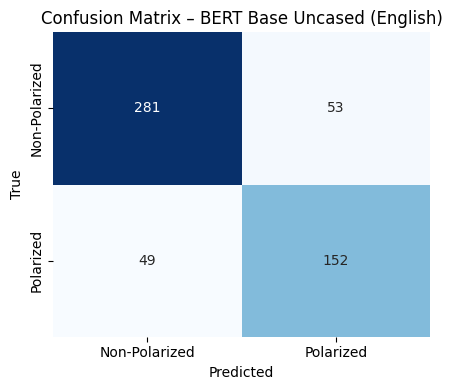

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
save_dir = "/content/drive/MyDrive/POLAR_Task_9/models/english_bert_uncased_evaluation"
os.makedirs(save_dir, exist_ok=True)


# evaluate on test set
metrics = trainer.evaluate(test_dataset)
print("\n=== Test Metrics ===")
for k, v in metrics.items():
    if isinstance(v, (int, float)):
        print(f"{k}: {v:.4f}")

# predictions
pred_out = trainer.predict(test_dataset)
y_true = pred_out.label_ids
y_pred = np.argmax(pred_out.predictions, axis=1)

# classification report
print("\n=== Detailed Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["Non-Polarized", "Polarized"], digits=4))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Polarized","Polarized"],
            yticklabels=["Non-Polarized","Polarized"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – BERT Base Uncased (English)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"), bbox_inches='tight', dpi=300)
plt.show()
with open(os.path.join(save_dir, "test_metrics.txt"), "w") as f:
    for k, v in metrics.items():
        if isinstance(v, (int, float)):
            f.write(f"{k}: {v:.4f}\n")
with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
    f.write(classification_report(y_true, y_pred, target_names=["Non-Polarized", "Polarized"], digits=4))



================================================================================
#Spanish
================================================================================

In [ ]:
#Spanish
# 2️⃣ Split into train/test
train_texts_spa, test_texts_spa, train_labels_spa, test_labels_spa = train_test_split(
    df_spa["text"].tolist(),
    df_spa["polarization"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_spa["polarization"]
)
print(f"Training samples: {len(train_texts_spa)} | Testing samples: {len(test_texts_spa)}")

# 3️⃣ Tokenize (Spanish BERT)
tokenizer_spa = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

def tokenize_spa(batch):
    return tokenizer_spa(batch["text"], padding="max_length", truncation=True, max_length=128)

train_df_spa = pd.DataFrame({"text": train_texts_spa, "labels": train_labels_spa})
test_df_spa  = pd.DataFrame({"text": test_texts_spa,  "labels": test_labels_spa})

train_dataset_spa = Dataset.from_pandas(train_df_spa).map(tokenize_spa, batched=True)
test_dataset_spa  = Dataset.from_pandas(test_df_spa ).map(tokenize_spa, batched=True)

train_dataset_spa = train_dataset_spa.with_format("torch", columns=["input_ids","attention_mask","labels"])
test_dataset_spa  = test_dataset_spa.with_format("torch",  columns=["input_ids","attention_mask","labels"])

print("✅ Spanish tokenization complete!")


Training samples: 2641 | Testing samples: 661


Map:   0%|          | 0/2641 [00:00<?, ? examples/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

✅ Spanish tokenization complete!


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import os
# 1️⃣ Load Spanish BERT model
model_spa = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=2)

# 2️⃣ Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision_macro": precision, "recall_macro": recall, "f1_macro": f1}
os.environ["WANDB_DISABLED"] = "true"


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 3️⃣ Training arguments
training_args_spa = TrainingArguments(
    output_dir="bert_spanish_runs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50
)

# 4️⃣ Trainer
trainer_spa = Trainer(
    model=model_spa,
    args=training_args_spa,
    train_dataset=train_dataset_spa,
    eval_dataset=test_dataset_spa,
    compute_metrics=compute_metrics
)

print("🚀 Starting training for Spanish...")
trainer_spa.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


🚀 Starting training for Spanish...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.580000,0.510816,0.754917,0.755062,0.754857,0.754849


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.580000,0.510816,0.754917,0.755062,0.754857,0.754849
2,0.388800,0.535535,0.741301,0.741402,0.741248,0.741242
3,0.274000,0.649193,0.744327,0.744591,0.744246,0.744212


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=498, training_loss=0.4316215687487499, metrics={'train_runtime': 11723.0248, 'train_samples_per_second': 0.676, 'train_steps_per_second': 0.042, 'total_flos': 521157222904320.0, 'train_loss': 0.4316215687487499, 'epoch': 3.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load Spanish Model

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

model_spa = BertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/POLAR_Task_9/models/spanish_bert_base_uncased",
    local_files_only=True
)
tokenizer_spa = BertTokenizer.from_pretrained(
    "/content/drive/MyDrive/POLAR_Task_9/models/spanish_bert_base_uncased",
    local_files_only=True
)

print("✅ Spanish BERT model loaded successfully from Drive!")



✅ Spanish BERT model loaded successfully from Drive!


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming df_spa is your Spanish dataframe
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_spa["text"].tolist(),
    df_spa["polarization"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_spa["polarization"]
)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

test_encodings = tokenizer_spa(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

test_dataset = TensorDataset(
    test_encodings["input_ids"],
    test_encodings["attention_mask"],
    torch.tensor(test_labels)
)


=== Test Metrics (Spanish BERT Uncased) ===
Accuracy:  0.7443
Precision: 0.7446
Recall:    0.7442
F1-score:  0.7442

=== Detailed Classification Report ===
               precision    recall  f1-score   support

Non-Polarized       0.75      0.73      0.74       329
    Polarized       0.74      0.76      0.75       332

     accuracy                           0.74       661
    macro avg       0.74      0.74      0.74       661
 weighted avg       0.74      0.74      0.74       661



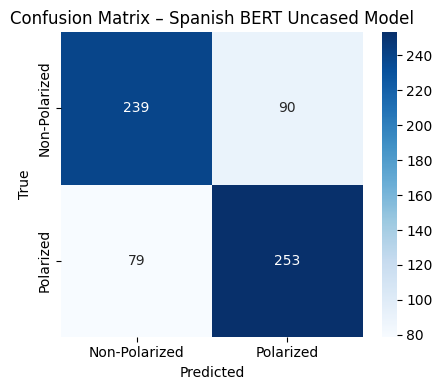


✅ Evaluation results saved to: /content/drive/MyDrive/POLAR_Task_9/models/spanish_bert_uncased_evaluation


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import os

# === Add these lines ===
save_dir = "/content/drive/MyDrive/POLAR_Task_9/models/spanish_bert_uncased_evaluation"
os.makedirs(save_dir, exist_ok=True)
# ========================

model_spa.eval()  # set model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(0, len(test_dataset), 16):  # batch size = 16
        batch = test_dataset[i:i+16]
        input_ids, attention_mask, labels = [t for t in batch]
        outputs = model_spa(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

print("=== Test Metrics (Spanish BERT Uncased) ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# === Save metrics ===
with open(os.path.join(save_dir, "test_metrics.txt"), "w") as f:
    f.write(f"Accuracy:  {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall:    {recall:.4f}\n")
    f.write(f"F1-score:  {f1:.4f}\n")

# Classification report
report = classification_report(all_labels, all_preds, target_names=["Non-Polarized", "Polarized"])
print("\n=== Detailed Classification Report ===")
print(report)

# === Save classification report ===
with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
    f.write(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Polarized", "Polarized"],
            yticklabels=["Non-Polarized", "Polarized"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Spanish BERT Uncased Model")
plt.tight_layout()

# === Save confusion matrix ===
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"), bbox_inches='tight', dpi=300)
plt.show()

print(f"\n✅ Evaluation results saved to: {save_dir}")


==============================================================================================
#German
==============================================================================================

In [ ]:
# 🇩🇪 --- GERMAN DATA PREPARATION (for BERT Uncased) ---

from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer

# ✅ 1️⃣ Split into train/test
train_texts_deu, test_texts_deu, train_labels_deu, test_labels_deu = train_test_split(
    df_deu["text"].tolist(),
    df_deu["polarization"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_deu["polarization"]
)
print(f"Training samples: {len(train_texts_deu)} | Testing samples: {len(test_texts_deu)}")

# ✅ 2️⃣ Load correct uncased German BERT tokenizer
tokenizer_deu = BertTokenizer.from_pretrained("bert-base-german-dbmdz-uncased")

# ✅ 3️⃣ Tokenization function
def tokenize_deu(batch):
    return tokenizer_deu(batch["text"], padding="max_length", truncation=True, max_length=128)

# ✅ 4️⃣ Create HuggingFace datasets
train_df_deu = pd.DataFrame({"text": train_texts_deu, "labels": train_labels_deu})
test_df_deu  = pd.DataFrame({"text": test_texts_deu,  "labels": test_labels_deu})

train_dataset_deu = Dataset.from_pandas(train_df_deu).map(tokenize_deu, batched=True)
test_dataset_deu  = Dataset.from_pandas(test_df_deu ).map(tokenize_deu, batched=True)

train_dataset_deu = train_dataset_deu.with_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset_deu  = test_dataset_deu.with_format("torch",  columns=["input_ids", "attention_mask", "labels"])

print("✅ German tokenization complete!")


Training samples: 2543 | Testing samples: 636


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/247k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/487k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

✅ German tokenization complete!


In [ ]:
# 🇩🇪 --- GERMAN MODEL TRAINING (BERT Uncased) ---

from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

# ✅ Define label mapping
id2label = {0: "Non-Polarized", 1: "Polarized"}
label2id = {"Non-Polarized": 0, "Polarized": 1}

# ✅ Load the model
model_deu = BertForSequenceClassification.from_pretrained(
    "bert-base-german-dbmdz-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# ✅ Define metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_macro': f1
    }

# ✅ Training setup (balanced, clean)
batch_size = 16
training_args = TrainingArguments(
    output_dir="bert_deu_runs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50,
    report_to="none"
)

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-dbmdz-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#  Trainer setup
trainer_deu = Trainer(
    model=model_deu,
    args=training_args,
    train_dataset=train_dataset_deu,
    eval_dataset=test_dataset_deu,
    tokenizer=tokenizer_deu,
    compute_metrics=compute_metrics
)

print("🚀 Starting training for German...")
trainer_deu.train()


/tmp/ipython-input-2890563062.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_deu = Trainer(


🚀 Starting training for German...


Step,Training Loss
500,0.626800


TrainOutput(global_step=954, training_loss=0.5128102332541028, metrics={'train_runtime': 225.7336, 'train_samples_per_second': 33.796, 'train_steps_per_second': 4.226, 'total_flos': 501818560335360.0, 'train_loss': 0.5128102332541028, 'epoch': 3.0})

In [ ]:
# 💾 Save German model and tokenizer to Google Drive
save_dir = "/content/drive/MyDrive/POLAR_Task_9/models/german_bert_base_uncased_model"

model_deu.save_pretrained(save_dir)
tokenizer_deu.save_pretrained(save_dir)

print(f"✅ German BERT model and tokenizer saved to: {save_dir}")


✅ German BERT model and tokenizer saved to: /content/drive/MyDrive/POLAR_Task_9/models/german_bert_base_uncased_model


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

model_ger = BertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/POLAR_Task_9/models/german_bert_base_uncased_model",
    local_files_only=True
)
tokenizer_ger = BertTokenizer.from_pretrained(
    "/content/drive/MyDrive/POLAR_Task_9/models/german_bert_base_uncased_model",
    local_files_only=True
)

print("✅ German BERT model loaded successfully from Drive!")


✅ German BERT model loaded successfully from Drive!


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/POLAR_Task_9/models/german_bert_base_uncased_model/eval_temp",
    per_device_eval_batch_size=16,
    report_to="none",
)

trainer_deu = Trainer(
    model=model_deu,
    args=training_args,
    tokenizer=tokenizer_deu,
    eval_dataset=test_dataset_deu  # <--- important
)


/tmp/ipython-input-2886074894.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_deu = Trainer(


In [ ]:
metrics_deu = trainer_deu.evaluate(test_dataset_deu)
preds_output = trainer_deu.predict(test_dataset_deu)


=== Test Metrics (German) ===


eval_loss: 0.9447
eval_accuracy: 0.6840
eval_precision_macro: 0.6836
eval_recall_macro: 0.6813
eval_f1_macro: 0.6816
eval_runtime: 4.6131
eval_samples_per_second: 137.8690
eval_steps_per_second: 8.6710
epoch: 3.0000

=== Detailed Classification Report (German) ===
               precision    recall  f1-score   support

Non-Polarized       0.69      0.73      0.71       334
    Polarized       0.68      0.63      0.65       302

     accuracy                           0.68       636
    macro avg       0.68      0.68      0.68       636
 weighted avg       0.68      0.68      0.68       636



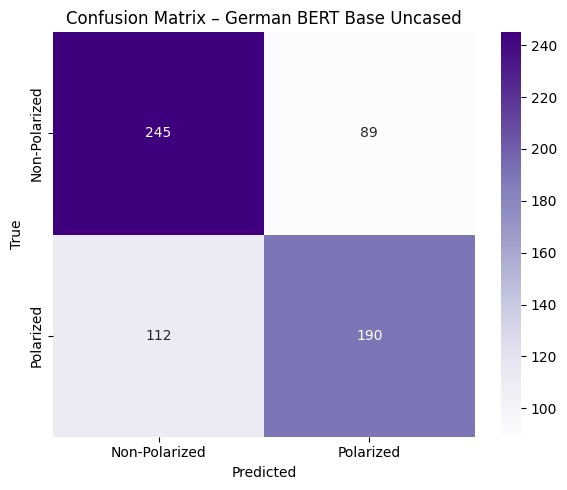


✅ All evaluation results saved to: /content/drive/MyDrive/POLAR_Task_9/models/german_bert_base_uncased_evaluation


In [ ]:
# 🇩🇪 --- GERMAN MODEL EVALUATION AND SAVE RESULTS ---

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# === Create save directory ===
save_dir = "/content/drive/MyDrive/POLAR_Task_9/models/german_bert_base_uncased_evaluation"
os.makedirs(save_dir, exist_ok=True)

# ✅ Evaluate on test set
print("=== Test Metrics (German) ===")
metrics_deu = trainer_deu.evaluate(eval_dataset=test_dataset_deu)  # pass eval dataset
for k, v in metrics_deu.items():
    print(f"{k}: {v:.4f}")

# === Save metrics ===
with open(os.path.join(save_dir, "test_metrics.txt"), "w") as f:
    for k, v in metrics_deu.items():
        f.write(f"{k}: {v:.4f}\n")

# ✅ Generate predictions
preds_output = trainer_deu.predict(test_dataset_deu)
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

# ✅ Detailed classification report
report = classification_report(labels, preds, target_names=["Non-Polarized", "Polarized"])
print("\n=== Detailed Classification Report (German) ===")
print(report)

# === Save classification report ===
with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
    f.write(report)

# ✅ Confusion matrix visualization
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Non-Polarized", "Polarized"],
            yticklabels=["Non-Polarized", "Polarized"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – German BERT Base Uncased")
plt.tight_layout()

# === Save confusion matrix ===
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"), bbox_inches='tight', dpi=300)
plt.show()

print(f"\n✅ All evaluation results saved to: {save_dir}")
